In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
sns.set()

데이터 읽기

In [2]:
# ETF 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2000-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('W').last()

# 수익률 벡터와 공분산 행렬
ret = data.pct_change().dropna()
ret_vec = ret.mean() * 52
cov_mat = ret.cov() * 52

[*********************100%***********************]  9 of 9 completed


In [3]:
# 색깔 팔레트
pal = sns.color_palette('Spectral', len(tickers))

### 시가총액 가중

In [4]:
# ETF별 시가총액 데이터 다운로드
cap_list = []
for ticker in tickers:
    market_cap = yf.Ticker(ticker).info['totalAssets']
    cap_list.append(market_cap)

In [5]:
# 시장 가중 비율 계산
caps = cap_list
caps_df = pd.Series(caps, index=tickers)
market_weights_df = caps_df / caps_df.sum()
market_weights_df

XLB    0.024491
XLE    0.155156
XLF    0.133487
XLI    0.058504
XLK    0.220510
XLP    0.081337
XLU    0.071980
XLV    0.183728
XLY    0.070808
dtype: float64

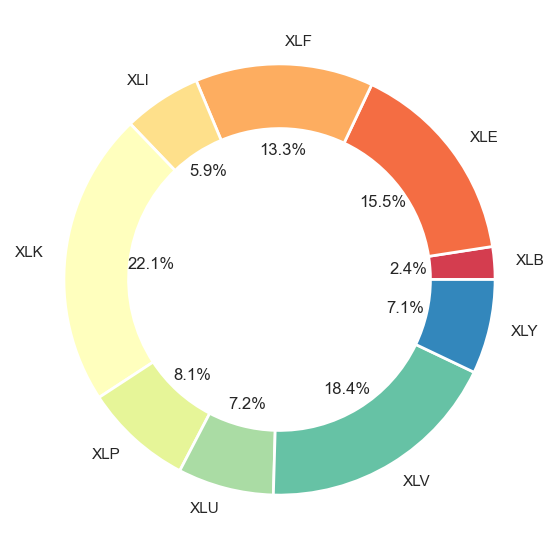

In [6]:
# 파이차트 시각화
plt.figure(figsize=(7, 7))
wedgeprops = {'width':0.3, 'edgecolor':'w', 'linewidth':2}
plt.pie(market_weights_df, labels=market_weights_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [7]:
# 시장 포트폴리오 수익률 평균 및 분산
mkt_port_ret = ret_vec.multiply(market_weights_df.values).sum()
mkt_port_var = np.matmul(market_weights_df.values.reshape(len(market_weights_df)).T, np.matmul(cov_mat.values, market_weights_df.values.reshape(len(market_weights_df))))

print(mkt_port_ret, mkt_port_var)

0.09310756662541413 0.032130091384103


In [8]:
# 위험회피계수
mkt_lambda = mkt_port_ret / np.sqrt(mkt_port_var)
print(mkt_lambda)

0.5194323527474316


### 블랙-리터만 역최적화

In [9]:
# 균형기대수익률
pi = np.dot(np.dot(mkt_lambda, cov_mat), market_weights_df)

In [10]:
pi_df = pd.Series(pi, index=tickers)
pi_df

XLB    0.018001
XLE    0.019138
XLF    0.021538
XLI    0.018260
XLK    0.018260
XLP    0.009357
XLU    0.011200
XLV    0.013399
XLY    0.018082
dtype: float64

### 투자자 전망과 기대수익률 그리고 전망의 불확실성 계산

In [11]:
# 투자자 전망
Q = np.array([0.0925, 0.005, 0.055])
P = [[0, 0, 0, 0, 0, 0, 1, 0, 0],
     [0, 0, 1, -1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 1, 0]]

# 위험조정상수
tau = 1 / len(data) * 52

# 투자자 전망의 불확실성 계산
omega = np.diag(np.diag(np.dot(np.dot(np.dot(tau, P), cov_mat), np.transpose(P))))

In [12]:
omega

array([[0.00146358, 0.        , 0.        ],
       [0.        , 0.00103078, 0.        ],
       [0.        , 0.        , 0.00131329]])

블랙-리터만 모델 최적화

In [13]:
# 투자자 전망과 합쳐진 균형초과수익률 계산
term1 = np.linalg.inv(np.dot(tau, cov_mat))
term2 = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), P)
term3 = np.dot(np.linalg.inv(np.dot(tau, cov_mat)), pi)
term4 = np.dot(np.dot(np.transpose(P), np.linalg.inv(omega)), Q)

# 블랙-리터만 모형에 기반한 사후 분포
bl_cov_mat = np.linalg.inv(term1 + term2)
bl_ret_vec = np.dot(bl_cov_mat, (term3 + term4))

In [14]:
# MVO 모델 가중치 산출 함수
def get_msr_weights(er, cov):

    # 자산개수
    noa = er.shape[0]

    # 가중치 초기값
    init_guess = np.repeat(1/noa, noa)

    # 자산 가중치 상하한
    bounds = ((0.0, 1.0), ) * noa

    # 레버리지 불가 제약조건
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}

    # 목적함수
    def neg_sharpe(weights, er, cov):
        r = weights.T @ er
        vol = np.sqrt(weights.T @ cov @ weights)
        return - r / vol

    # 최적화 수행
    res = minimize(neg_sharpe,
                   init_guess,
                   args=(er, cov),
                   method='SLSQP',
                   constraints=(weights_sum_to_1,),
                   bounds=bounds)
    
    return res.x

In [15]:
# BL 포트폴리오 가중치
bl_weights = get_msr_weights(bl_ret_vec, bl_cov_mat)

# BL 포트폴리오 수익률
bl_ret = np.dot(bl_weights, bl_ret_vec)

# BL 포트폴리오 변동성
bl_vol = np.sqrt(np.dot(bl_weights.T, np.dot(bl_cov_mat, bl_weights)))


In [16]:
# BL 포트폴리오 수익률과 변동성
print(bl_ret, bl_vol)

0.050725380325901515 0.02081009397897475


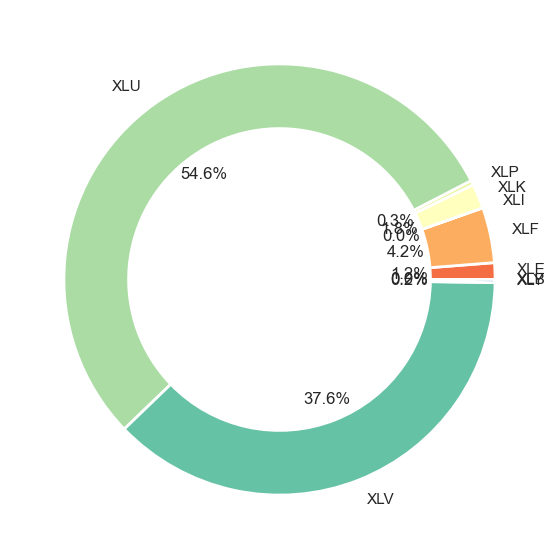

In [17]:
# 블랙-리터만 투자 가중치 데이터프레임
bl_weights_df = pd.Series(bl_weights, index=tickers)

# 파이차트 시각화
plt.figure(figsize=(7, 7))
wedgeprops = {'width':0.3, 'edgecolor':'w', 'linewidth':2}
plt.pie(bl_weights_df, labels=bl_weights_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()